# Covid-19 analysis
**January 2021**: From 14 December 2020 the *European Centre for Disease Prevention and Control* for several reasons discontinued providing Covid-19 data on a daily basis. Instead weekly updates are published every Thursday. This notebook is not updated to reflect this new situation as I want to keep this first approach. Instead a new notebook [Covid-19 analysis updated](CovidAnalysisUpdated.ipynb) contains all changes to analyse data provided weekly and is extended with plots to view the status in multiple countries.<br><br>
## Intrduction
This Python3 notebook is based on the original [Pharo Smalltalk version](https://github.com/olekscode/CovidAnalysis) by Oleksandr Zaitsev. <br> The dataset for this Covid-19 analysis is publicly available ([see](#Download-latest-COVID-19-data)) and updated daily. Where appropriate some code extensions have been added to view the supplied data from a different angle.

#### Disclaimer 
August 2020. To prevent inappropriate conclusions drawn on this highly actual subject:
* As a Data Science beginner this Covid-19 analysis is purely intended for educational purposes.
* The outcome of the code cells in this notebook should be regarded as the *technical* result of the code and not be interpreted otherwise.
* I have no opinion on the dataset provided nor am I responsible for possible misinterpretation of the outcome

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

### Download latest COVID-19 data
Download the latest COVID-19 data from the [European Centre for Disease Prevention](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

In [2]:
def dataCsvURL():
    return 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataCsvFile():
    return dataDirectory() + 'covidData.csv'

In [5]:
#Let's give it a try and save to CSV file
covidFile = requests.get(dataCsvURL())
open(dataCsvFile(), 'wb').write(covidFile.content)

3072209

### Read and clean data
Now read the data from the CSV file into a dataframe using pandas. Clean up to show the relevant columns.

In [6]:
def columnsToDisplay():
    return ["dateRep", "cases", "deaths", "countriesAndTerritories","popData2019"]

In [7]:
def columnsRenameDict():
    return {'dateRep':'date', 'countriesAndTerritories':'country', 'popData2019':'population' }

In [8]:
# Change date format to DD-MONTH-YYYY
# Convert population to integer. Caution: astype(int) gives error "Cannot convert non-finite values (NA or inf) to integer"
def preProcessing(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['date'] = df['date'].dt.strftime("%d %B %Y")
    df['population'] = df['population'].astype('Int64')

In [9]:
#df = pd.read_csv(dataCsvFile())
df = pd.read_csv(dataCsvFile(), usecols=columnsToDisplay())
df.rename(columns=columnsRenameDict(), inplace=True)
preProcessing(df)
df.head(20)


,date,cases,deaths,country,population
0,24 September 2020,25,5,Afghanistan,38041757
1,23 September 2020,71,2,Afghanistan,38041757
2,22 September 2020,30,3,Afghanistan,38041757
3,21 September 2020,0,0,Afghanistan,38041757
4,20 September 2020,125,4,Afghanistan,38041757
5,19 September 2020,47,1,Afghanistan,38041757
6,18 September 2020,0,0,Afghanistan,38041757
7,17 September 2020,17,0,Afghanistan,38041757
8,16 September 2020,40,10,Afghanistan,38041757
9,15 September 2020,99,6,Afghanistan,38041757


#### One country
The core of western civilization and a popular holiday destination:

In [10]:
#df[df.country=='Greece'].head() identical to:
df.query("country == 'Greece'").head()

,date,cases,deaths,country,population
16539,24 September 2020,358,5,Greece,10724599
16540,23 September 2020,333,8,Greece,10724599
16541,22 September 2020,453,6,Greece,10724599
16542,21 September 2020,164,7,Greece,10724599
16543,20 September 2020,240,4,Greece,10724599


### Top 10 countries of reported cases  (in numbers)
This is an aggregate action on the dataframe. As a beginner in Data science and Pandas I find it cumbersome to get these top 10 countries of reported cases. IMO **Pharo's Smalltalk** solution below is much cleaner and easier to understand.

```
(df group: 'cases' by: 'country' aggregateUsing: #sum)
	sortDescending
	head: 10.
```

To find the 10 countries having the least reported cases simply replace `head` by `tail`.

In [11]:
#df['country'].count()
#df['cases'].sum()
#df.sum()

casesPerCountry = df.groupby('country').sum()[['cases']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['cases'], ascending=False)
sortedCasesPerCountry.head(10)

,cases
country,
United_States_of_America,6934204
India,5732518
Brazil,4624885
Russia,1122241
Colombia,784268
Peru,782695
Mexico,710049
Spain,693556
South_Africa,665188


### Top 10 countries of reported cases  (relative to population)
Another approach is to collect the number of cases in a country relative to the population.

In [12]:
# Find 10 countries with relatively highest cases
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['cases (%)']=casesPerCountry['cases'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['cases (%)'], ascending=False).head(10)

,population,cases (%)
country,,
Qatar,2832071,4.384601
Bahrain,1641164,4.046031
Aruba,106310,3.500141
Panama,4246440,2.543071
Kuwait,4207077,2.407824
Peru,32510462,2.407517
Israel,8519373,2.402642
Chile,18952035,2.373903
Andorra,76177,2.301220


### Top 10 countries of reported deaths (in numbers)
To find the 10 countries having the least reported Covid-19 deaths simply replace `head` by `tail`.


In [13]:
casesPerCountry = df.groupby('country').sum()[['deaths']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['deaths'], ascending=False)
sortedCasesPerCountry.head(10)

,deaths
country,
United_States_of_America,201909
Brazil,138977
India,91149
Mexico,74949
United_Kingdom,41862
Italy,35758
Peru,31870
France,31459
Spain,31034


### Top 10 countries of reported deaths  (relative to population)
Another approach is to collect the number of deaths in a country relative to the population.

In [14]:
# Find 10 countries with relatively highest deaths
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['deaths (%)']=casesPerCountry['deaths'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['deaths (%)'], ascending=False).head(10)

,population,deaths (%)
country,,
San_Marino,34453,0.121905
Peru,32510462,0.098030
Belgium,11455519,0.086936
Andorra,76177,0.069575
Bolivia,11513102,0.067150
Spain,46937060,0.066118
Brazil,211049519,0.065850
Chile,18952035,0.065138
Ecuador,17373657,0.064298


### Covid-19 spread in The Netherlands

In [34]:
country = "Luxembourg"
df_country = df[df.country==country]
relevant_columns = ['date', 'cases', 'deaths']
covid_df_country = df_country[relevant_columns]
covid_df_country

,date,cases,deaths
24938,24 September 2020,74,0
24939,23 September 2020,100,0
24940,22 September 2020,112,0
24941,21 September 2020,86,0
24942,20 September 2020,0,0
...,...,...,...
25195,04 January 2020,0,0
25196,03 January 2020,0,0
25197,02 January 2020,0,0
25198,01 January 2020,0,0


### Max daily cases in The Netherlands
Find date when most cases were reported

In [16]:
maxDailyCases = covid_df_country['cases'].max()
print('Max daily cases ', country, ' ' , maxDailyCases)

covid_df_country[(covid_df_country.cases==maxDailyCases)]


Max daily cases  Netherlands   2351


,date,cases,deaths
29107,24 September 2020,2351,5


### Max daily deaths in The Netherlands
Find when most deaths were reported

In [17]:
maxDailyDeaths = covid_df_country['deaths'].max()
print('Max daily cases ', country, ' ' , maxDailyDeaths)
covid_df_country[(covid_df_country.deaths==maxDailyDeaths)]

Max daily cases  Netherlands   234


,date,cases,deaths
29276,08 April 2020,777,234


### Cumulative sum of cases and deaths
To find the total number of reported cases and deaths up to a date in the Netherlands

In [18]:
covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases'].cumsum(axis = 0)[::-1]
covid_df_country['cumulativeDeaths']=covid_df_country.loc[::-1, 'deaths'].cumsum(axis = 0)[::-1]
covid_df_country

<ipython-input-18-21889752aade>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases'].cumsum(axis = 0)[::-1]


,date,cases,deaths,cumulativeCases,cumulativeDeaths
29107,24 September 2020,2351,5,100493,6287
29108,23 September 2020,2243,10,98142,6282
29109,22 September 2020,2215,2,95899,6272
29110,21 September 2020,1843,4,93684,6270
29111,20 September 2020,1882,2,91841,6266
...,...,...,...,...,...
29371,04 January 2020,0,0,0,0
29372,03 January 2020,0,0,0,0
29373,02 January 2020,0,0,0,0
29374,01 January 2020,0,0,0,0


###  Initial growth in cases
How long did it take to spread from 1 to 100 cases? And, next, how many days from 100 to 1000 cases?

In [19]:
firstCase = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases > 0)].date).min()
plus100Cases = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases >= 100)].date).min()
plus1000Cases = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases >= 1000)].date).min()
print ("From 1st case to 100 or above in ", plus100Cases - firstCase)
print ("From 100 or above to 1000 or above in ", plus1000Cases - plus100Cases)

From 1st case to 100 or above in  8 days 00:00:00
From 100 or above to 1000 or above in  9 days 00:00:00


In [21]:
#Sort by date
covid_df_country['date'] = pd.to_datetime(covid_df_country['date'], dayfirst=True)
covid_df_country.sort_values(by='date')


,date,cases,deaths,cumulativeCases,cumulativeDeaths
29375,2019-12-31,0,0,0,0
29374,2020-01-01,0,0,0,0
29373,2020-01-02,0,0,0,0
29372,2020-01-03,0,0,0,0
29371,2020-01-04,0,0,0,0
...,...,...,...,...,...
29111,2020-09-20,1882,2,91841,6266
29110,2020-09-21,1843,4,93684,6270
29109,2020-09-22,2215,2,95899,6272
29108,2020-09-23,2243,10,98142,6282


### Plot data for a country
How is Covid-19 moving in time? This plot merely prints the daily figures. The whereabouts of the data should be given before any conclusion may be drawn. E.g. consider the fact that the test capacity in a country is considerably higher than after the outbreak of the virus and has an important impact on the number of reported contaminations. However the number of confirmed deaths might be a more reliable indicator.

Text(0, 0.5, 'Daily Count')

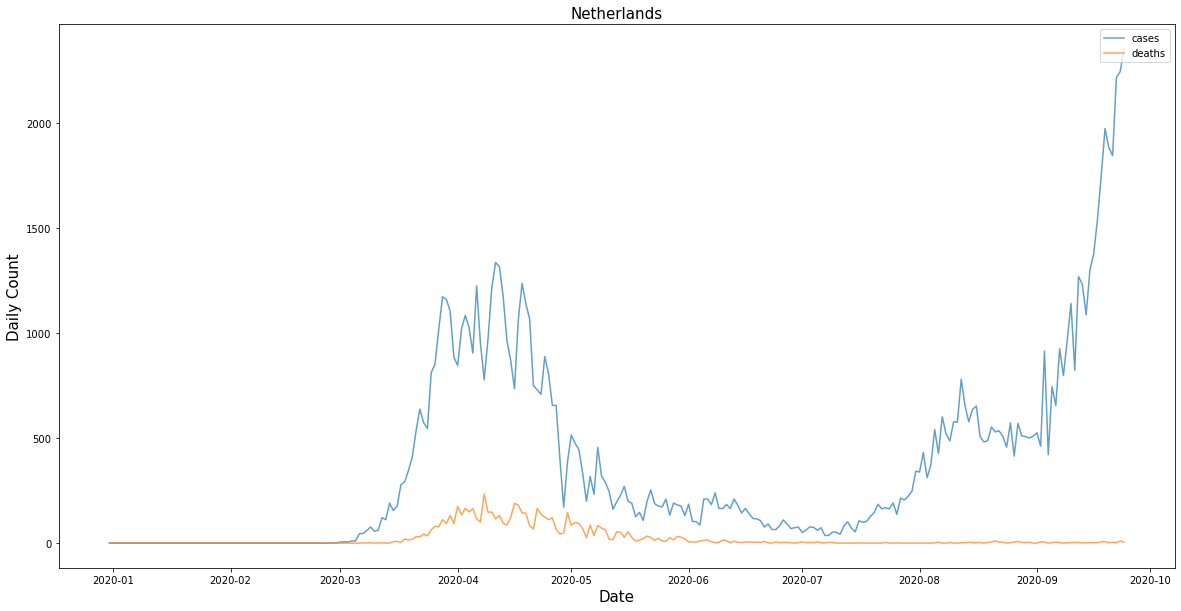

In [22]:
for i in ['cases', 'deaths']:
    plt.rcParams["figure.figsize"] = [20,10]
    plt.plot(covid_df_country['date'],covid_df_country[i], alpha=0.7, label=i)
    plt.legend(loc="upper right")
plt.title(country, fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Daily Count', fontsize=15)
